In [8]:
import calc_footprint_FFP_climatology as myfootprint_s
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import pyproj as proj

In [11]:
zm_s = 2.78 #Measurement height [m]
h_c = 0.05 #Height of canopy [m]
h_s = 2000. #Height of boundary layer [m]
#full_df['ol'] = zm_s/full_df['z/L'] #Monin-Obukhov length [m]
dx = 1. #Model resolution [m]
origin_d = 600. #Model distance from origin [m]

#Convert local coordinates to local UTM (Eagle Lake: UTM 12)
station_coord = (-112.050747,41.166695) #
in_proj = proj.Proj(init='EPSG:4326')
out_proj = proj.Proj(init='EPSG:32612')
(station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)

#Calculate footprint
temp_ffp = myfootprint_s.FFP_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],dx=dx,dy=dx,
                                zm=zm_s,z0=h_c*.15,h=h_s,rs=None,
                                ol=-10,sigmav=2.,umean=1.,
                                ustar=.4,wind_dir=260.,
                                crop=0,fig=0,verbosity=0)

#Assign footprint (f_2d) and coordinate (x_2d, y_2d) arrays
f_2d = np.array(temp_ffp['fclim_2d'])
x_2d = np.array(temp_ffp['x_2d']) + station_x
y_2d = np.array(temp_ffp['y_2d']) + station_y
f_2d = f_2d*dx**2

#Mask out any values below the 90% cumulative threshold
#Sort f_2d values in reverse and get the cumulative sum
t_f2d = f_2d.flatten()
df_f2d = pd.DataFrame({'f2d':t_f2d}).sort_values(by='f2d').iloc[::-1]
fullsum = df_f2d['f2d'].sum()
df_f2d['cumsum_f2d'] = df_f2d['f2d'].cumsum()

#Group f_2d values and see where the threshold is reached
gb_df_f2d = df_f2d.groupby('f2d',as_index=True).mean()
diff = abs(gb_df_f2d['cumsum_f2d']-0.9)
cutoff = diff.idxmin()

#Mask out values below threshold
f_2d = np.where(f_2d>=cutoff,f_2d,np.nan)
print(f'Total Footprint: {np.nansum(f_2d):.2f}') #Divide the ET you get by this number to get the total ET

Total Footprint: 0.90


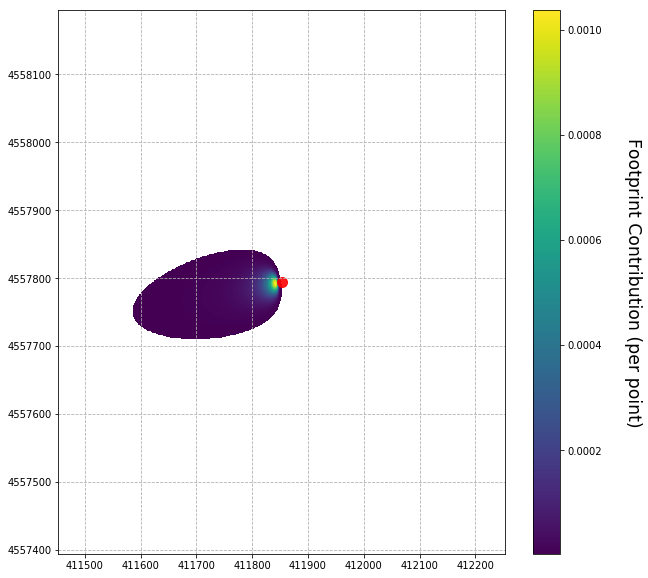

In [13]:
#Plot out footprint (station marker will be in red)
fig,ax = plt.subplots(**{'figsize':(10,10)})

fprint = ax.pcolormesh(x_2d,y_2d,f_2d)
cbar = fig.colorbar(fprint)
cbar.set_label(label='Footprint Contribution (per point)',fontsize='xx-large',rotation=270,labelpad=40)
ax.grid(ls='--')
ax.scatter(station_x,station_y,s=100,c='red',alpha=.9)
plot_dist = origin_d - 200.
ax.set_xlim(station_x-plot_dist,station_x+plot_dist)
ax.set_ylim(station_y-plot_dist,station_y+plot_dist)
plt.show()